In [1]:
import os
from pathlib import Path
import numpy as np
import skimage.exposure
import warnings
from io import StringIO
from scipy.sparse import coo_matrix
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import skimage.segmentation
import random
from scipy.sparse import coo_array
from scipy.io import loadmat
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['SimHei']  # 如果你显示中文，改为你系统支持的


In [2]:
def load_pavia_university_with_full_test(data_path: Path, candidate_counts: dict, num_train_per_class=10, seed=42):
    """
    加载 Pavia University 数据集：
    - 从每类中抽取固定数量作为候选样本
    - 从候选中抽取 10 个作为训练样本
    - 所有 ground truth 像素都作为测试样本（包括候选/训练区域）
    """
    random.seed(seed)
    np.random.seed(seed)

    pavia_data = loadmat(data_path / 'PaviaU.mat')['paviaU']
    gt = loadmat(data_path / 'PaviaU_gt.mat')['paviaU_gt']
    h, w, c = pavia_data.shape

    label_dict = {
        1: 'Asphalt road', 2: 'Meadows', 3: 'Gravel',
        4: 'Trees', 5: 'Painted metal sheets', 6: 'Bare Soil',
        7: 'Bitumen', 8: 'Self-Blocking Bricks', 9: 'Shadows',
    }

    train_rows, train_cols, train_data = [], [], []
    candidate_rows, candidate_cols, candidate_data = [], [], []

    for label, cand_count in candidate_counts.items():
        coords = np.argwhere(gt == label)
        if len(coords) < cand_count:
            raise ValueError(f" 类 {label} 样本不足，只有 {len(coords)}，无法抽取 {cand_count} 个候选样本")
        np.random.shuffle(coords)

        candidate_coords = coords[:cand_count]
        train_coords = candidate_coords[:num_train_per_class]

        # 训练样本
        for r, c in train_coords:
            train_rows.append(r)
            train_cols.append(c)
            train_data.append(label)

        # 候选样本（包含训练）
        for r, c in candidate_coords:
            candidate_rows.append(r)
            candidate_cols.append(c)
            candidate_data.append(label)

    # 构建稀疏矩阵
    train_truth = coo_matrix((train_data, (train_rows, train_cols)), shape=(h, w), dtype=int)
    candidate_truth = coo_matrix((candidate_data, (candidate_rows, candidate_cols)), shape=(h, w), dtype=int)

    #  测试集直接包含所有 ground truth
    test_rows, test_cols = np.where(gt > 0)
    test_data = gt[test_rows, test_cols]
    test_truth = coo_matrix((test_data, (test_rows, test_cols)), shape=(h, w), dtype=int)

    info = {
        'n_band': c,
        'width': w,
        'height': h,
        'label_dict': label_dict
    }

    return pavia_data.transpose(2, 0, 1), train_truth, candidate_truth, test_truth, info
data_path = Path(r"E:\code\-\对比学习\fx\otherdataset")

candidate_counts = {
    1: 548, 2: 540, 3: 392,
    4: 524, 5: 265, 6: 532,
    7: 375, 8: 514, 9: 231
}

pavia, train_truth, candidate_truth, test_truth, info = load_pavia_university_with_full_test(
    data_path,
    candidate_counts=candidate_counts,
    num_train_per_class=15
)

print(f"Pavia University shape: {pavia.shape}")
print(f"Train samples: {train_truth.count_nonzero()}")         #  90
print(f"Candidate samples: {candidate_truth.count_nonzero()}") #  3921
print(f"Test samples: {test_truth.count_nonzero()}")           #  42776
def contrastive_loss_ce_hard_negatives(features_a, features_b, temperature=0.1, num_negatives=2):
    """
    Cross-Entropy Contrastive Loss using hardest negative sampling.
    - Each anchor (features_a[i]) uses its positive (features_b[i])
    - Negatives are selected as least similar samples in [features_a; features_b]
    """

    batch_size = features_a.size(0)

    # Normalize
    features_a = F.normalize(features_a, dim=1)
    features_b = F.normalize(features_b, dim=1)

    # Combine: total 2N candidates
    all_features = torch.cat([features_a, features_b], dim=0)  # [2N, D]

    # Cosine sim between anchors and all
    sim_matrix = torch.matmul(features_a, all_features.T) / temperature  # [N, 2N]

    # Mask out own positive (at i + batch_size)
    pos_indices = torch.arange(batch_size, device=features_a.device)
    sim_matrix[torch.arange(batch_size), pos_indices + batch_size] = float('-inf')

    # Select top-k lowest similarity (hard negatives)
    _, neg_indices = torch.topk(sim_matrix, k=num_negatives, dim=1, largest=False)  # [N, k]

    # Construct new logits: [N, 1 + k] → positive + k negatives
    pos_sim = torch.sum(features_a * features_b, dim=1, keepdim=True) / temperature  # [N, 1]
    neg_sims = torch.gather(sim_matrix, 1, neg_indices)  # [N, k]
    logits = torch.cat([pos_sim, neg_sims], dim=1)  # [N, 1+k]

    # Labels: positive is index 0
    labels = torch.zeros(batch_size, dtype=torch.long, device=features_a.device)

    loss = F.cross_entropy(logits, labels)
    return loss

Pavia University shape: (103, 610, 340)
Train samples: 135
Candidate samples: 3921
Test samples: 42776


In [3]:
# 统计 train_truth 中的类别数量（非零值的唯一值数量）
num_classes = len(set(train_truth.data))
num_classes



9

In [25]:
from sklearn.decomposition import PCA
import numpy as np

def apply_pca_on_candidate(hsi_data, candidate_truth, num_components=40, use_pca=True):
    """
    在 candidate_truth 区域进行 PCA 或保留原始光谱，返回结果格式统一。

    返回：
    - data: shape [C, H, W]，只在候选区域填值，其余为 0
    - samples: shape [N, C]，候选像素的特征
    - coords: List of (row, col)
    - explained_variance_ratio 或 None
    """
    c, h, w = hsi_data.shape
    rows, cols = candidate_truth.row, candidate_truth.col
    spectra = hsi_data[:, rows, cols].T  # shape: (N, C)

    coords = list(zip(rows, cols))

    if use_pca:
        pca = PCA(n_components=num_components)
        reduced = pca.fit_transform(spectra)  # shape: (N, num_components)
        result_c = num_components
        final_data = reduced
        var_ratio = pca.explained_variance_ratio_
    else:
        reduced = spectra  # shape: (N, C)
        result_c = c
        final_data = reduced
        var_ratio = None

    # 构建 [C, H, W] 格式，只填候选区域
    candidate_data = np.zeros((result_c, h, w), dtype=np.float32)
    for i, (r, c_) in enumerate(coords):
        candidate_data[:, r, c_] = final_data[i]

    return candidate_data, reduced, coords, var_ratio

com = 60

# 应用 PCA 降维
pca_candidate_data, reduced_samples, coords, var_ratio = apply_pca_on_candidate(pavia, candidate_truth, num_components=com)
#不用pca降维
#original_candidate_data, raw_samples, coords, _
#pca_candidate_data, reduced_samples, coords, var_ratio = apply_pca_on_candidate(pavia, candidate_truth, use_pca=False)

print(f"候选区降维结果 shape: {pca_candidate_data.shape}")



候选区降维结果 shape: (60, 610, 340)


In [26]:

def split_cube(hsi_cube):
    """
    通道维度为奇数时，丢弃最后一个通道，保持对称划分。

    将高光谱立方块沿通道维度均匀切分。
    参数:
        hsi_cube: torch.Tensor, 形状为 [H, W, C]
    返回:
        hsi_cube_a, hsi_cube_b: 两个子立方块
    """
    _, _, c = hsi_cube.shape
    if c % 2 != 0:
        hsi_cube = hsi_cube[:, :, :c - 1]  # 丢掉最后一个通道
    c1 = hsi_cube.shape[2] // 2
    return hsi_cube[:, :, :c1], hsi_cube[:, :, c1:]

# 提取 11x11 的立方块
s = 11  # 立方块的宽和高
patch_size = (s, s)

def extract_cube(data, x, y, size):
    """
    从高光谱图像中提取一个立方块，并在边缘不足时进行填充。
    参数:
        data: 高光谱数据, 形状为 [C, H, W]
        x, y: 中心像素的坐标
        size: 立方块的大小 (s, s)
    返回:
        cube: 提取的立方块, 形状为 [C, s, s]
    """
    c, h, w = data.shape
    half_size = size[0] // 2
    x_min = max(0, x - half_size)
    x_max = min(h, x + half_size + 1)
    y_min = max(0, y - half_size)
    y_max = min(w, y + half_size + 1)
    
    cube = data[:, x_min:x_max, y_min:y_max]

    # 进行对称填充，确保形状为 (C, s, s)
    pad_width = [
        (0, 0),  # 不填充通道维度
        (max(0, half_size - x), max(0, x + half_size + 1 - h)),  # 高度填充
        (max(0, half_size - y), max(0, y + half_size + 1 - w)),  # 宽度填充
    ]
    cube = np.pad(cube, pad_width, mode="reflect")
    return cube

# 提取某像素点周围的立方块
x, y = 100, 100  # 中心像素位置
cube = extract_cube(pca_candidate_data, x, y, patch_size)
print("提取的立方块形状:", cube.shape)  # (40, 11, 11)
# 切分通道
cube_tensor = torch.tensor(cube).permute(1, 2, 0)  # 转换为 [H, W, C]
cube_a, cube_b = split_cube(cube_tensor)

print("子立方块 A 形状:", cube_a.shape)  # (11, 11, 20)
print("子立方块 B 形状:", cube_b.shape)  # (11, 11, 20)


提取的立方块形状: (60, 11, 11)
子立方块 A 形状: torch.Size([11, 11, 30])
子立方块 B 形状: torch.Size([11, 11, 30])


In [7]:
print(torch.cuda.is_available())  # 如果为 False，CUDA 不可用
print(torch.cuda.current_device())  # 当前设备编号
print(torch.cuda.get_device_name(0))  # 查看设备名称


True
0
NVIDIA GeForce RTX 3050 Laptop GPU


In [27]:
import torch.nn as nn
import torch.nn.functional as F

class FeatureExtractor(nn.Module):
    def __init__(self, input_channels=20):
        """
        特征提取网络。
        参数:
            input_channels: 输入的通道数，例如 20。
        """
        super(FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)  # 第一层卷积
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 第二层卷积
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 第三层卷积
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)  # 最大池化层
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))  # 卷积 + 批归一化 + 激活 + 池化
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        return x.view(x.size(0), -1)  # 展平特征


In [9]:
print(cube_a.dtype, cube_a.device)
print(cube_b.dtype, cube_b.device)


torch.float32 cpu
torch.float32 cpu


In [28]:
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=128, output_dim=8):
        """
        特征投影模块。
        参数:
            input_dim: 输入特征的维度，例如 128。
            output_dim: 投影后的维度，例如 8。
        """
        super(ProjectionHead, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return F.normalize(self.fc(x), dim=1)  # 投影后的特征归一化


def contrastive_loss(features_a, features_b, temperature=1.0):
    """
    计算对比损失。
    参数:
        features_a, features_b: 投影后的特征，形状为 [batch_size, projection_dim]
        temperature: 温度系数
    返回:
        loss: 对比损失值
    """
    batch_size = features_a.size(0)
    features = torch.cat([features_a, features_b], dim=0)  # 拼接特征
    sim_matrix = F.cosine_similarity(features.unsqueeze(1), features.unsqueeze(0), dim=2)  # 计算相似度
    sim_matrix = sim_matrix / temperature

    # 构造标签
    labels = torch.arange(batch_size, device=features_a.device)
    labels = torch.cat([labels, labels], dim=0)

    # 使用交叉熵损失
    loss = F.cross_entropy(sim_matrix, labels)
    return loss


Epoch [1/50], Loss: 0.6149
Epoch [2/50], Loss: 0.5133
Epoch [3/50], Loss: 0.4953
Epoch [4/50], Loss: 0.4857
Epoch [5/50], Loss: 0.4769
Epoch [6/50], Loss: 0.4758
Epoch [7/50], Loss: 0.4703
Epoch [8/50], Loss: 0.4745
Epoch [9/50], Loss: 0.4629
Epoch [10/50], Loss: 0.4677
Epoch [11/50], Loss: 0.4673
Epoch [12/50], Loss: 0.4713
Epoch [13/50], Loss: 0.4597
Epoch [14/50], Loss: 0.4650
Epoch [15/50], Loss: 0.4652
Epoch [16/50], Loss: 0.4575
Epoch [17/50], Loss: 0.4692
Epoch [18/50], Loss: 0.4602
Epoch [19/50], Loss: 0.4575
Epoch [20/50], Loss: 0.4687
Epoch [21/50], Loss: 0.4598
Epoch [22/50], Loss: 0.4587
Epoch [23/50], Loss: 0.4627
Epoch [24/50], Loss: 0.4671
Epoch [25/50], Loss: 0.4593
Epoch [26/50], Loss: 0.4561
Epoch [27/50], Loss: 0.4578
Epoch [28/50], Loss: 0.4563
Epoch [29/50], Loss: 0.4519
Epoch [30/50], Loss: 0.4522
Epoch [31/50], Loss: 0.4555
Epoch [32/50], Loss: 0.4607
Epoch [33/50], Loss: 0.4580
Epoch [34/50], Loss: 0.4538
Epoch [35/50], Loss: 0.4540
Epoch [36/50], Loss: 0.4547
E

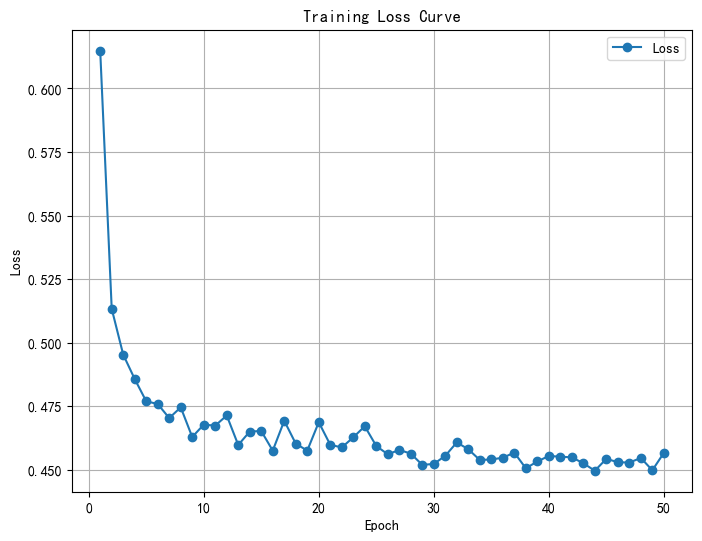

In [29]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

class CandidatePatchDataset(Dataset):
    def __init__(self, pca_data, coords, patch_size=11):
        self.data = pca_data
        self.coords = coords
        self.patch_size = patch_size

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        x, y = self.coords[idx]
        cube = extract_cube(self.data, x, y, (self.patch_size, self.patch_size))  # [C, H, W]
        cube = torch.tensor(cube).permute(1, 2, 0)  # [H, W, C]
        cube_a, cube_b = split_cube(cube)
        cube_a = cube_a.permute(2, 0, 1)
        cube_b = cube_b.permute(2, 0, 1)
        return cube_a, cube_b

class MultiPositivePatchDataset(Dataset):
    def __init__(self, pca_data, coords, patch_size=11):
        self.data = pca_data
        self.coords = coords
        self.patch_size = patch_size

        # 展平坐标：一个中心对应 4 个邻居位置
        self.flattened_coords = []
        for x, y in coords:
            self.flattened_coords += [
                (x, y, x-1, y),  # 上
                (x, y, x+1, y),  # 下
                (x, y, x, y-1),  # 左
                (x, y, x, y+1),  # 右
            ]

    def __len__(self):
        return len(self.flattened_coords)

    def __getitem__(self, idx):
        x1, y1, x2, y2 = self.flattened_coords[idx]
        patch_a = extract_cube(self.data, x1, y1, (self.patch_size, self.patch_size))
        patch_b = extract_cube(self.data, x2, y2, (self.patch_size, self.patch_size))
        patch_a = torch.tensor(patch_a, dtype=torch.float32)
        patch_b = torch.tensor(patch_b, dtype=torch.float32)
        return patch_a, patch_b

class MultiPositivePatchDataset1(Dataset):
    def __init__(self, pca_data, coords, patch_size=11):
        self.data = pca_data
        self.coords = coords
        self.patch_size = patch_size

        # 展平坐标：一个中心对应 4 个邻居位置
        self.flattened_coords = []
        for x, y in coords:
            self.flattened_coords += [
                (x, y, x-1, y),  # 上
                (x, y, x+1, y),  # 下
                (x, y, x, y-1),  # 左
                (x, y, x, y+1),  # 右
            ]

    def __len__(self):
        return len(self.flattened_coords)

    def __getitem__(self, idx):
        x1, y1, x2, y2 = self.flattened_coords[idx]
        patch_a = extract_cube(self.data, x1, y1, (self.patch_size, self.patch_size))
        patch_b = extract_cube(self.data, x2, y2, (self.patch_size, self.patch_size))
        
        patch_a = torch.tensor(patch_a, dtype=torch.float32)  # shape: (C, H, W)
        patch_b = torch.tensor(patch_b, dtype=torch.float32)

        # 拆分光谱维度 C
        C = patch_a.shape[0]
        c_half = C // 2
        a1, a2 = patch_a[:c_half], patch_a[c_half:]
        b1, b2 = patch_b[:c_half], patch_b[c_half:]

        # 组合成混合补丁
        patch_mix1 = torch.cat([a1, b1], dim=0)  # shape: (C, H, W)
        patch_mix2 = torch.cat([a2, b2], dim=0)

        return patch_mix1, patch_mix2
    
pca_data_tensor = torch.tensor(pca_candidate_data).float()
dataset = MultiPositivePatchDataset1(pca_data_tensor, coords)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)  # 每 batch 会生成 64×4=256 对

# 初始化网络和优化器
feature_extractor = FeatureExtractor(input_channels=com).cuda()
projection_head = ProjectionHead(input_dim=128, output_dim=8).cuda()
optimizer = optim.Adam(list(feature_extractor.parameters()) + list(projection_head.parameters()), lr=1e-4)

# 训练循环
num_epochs = 50
loss_values = []
temperature = 1.0

for epoch in range(num_epochs):
    feature_extractor.train()
    projection_head.train()
    epoch_loss = 0

    for cube_a, cube_b in dataloader:  # ⬅️ 直接解包两个 batch tensor
        cube_a, cube_b = cube_a.cuda(), cube_b.cuda()

        # 提取特征
        features_a = feature_extractor(cube_a)
        features_b = feature_extractor(cube_b)

        # 投影
        proj_a = projection_head(features_a)
        proj_b = projection_head(features_b)

        # 计算对比损失
        loss = contrastive_loss_ce_hard_negatives(proj_a,proj_b, temperature=1, num_negatives=5)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    loss_values.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # 在第50、100、150轮存储模型
    if (epoch + 1) in [50, 100, 150]:
        model_path = f'final/Pavia_lin_{epoch+1}_model1_60ep.pth'
        torch.save(
            {
                'epoch': epoch + 1,
                'feature_extractor_state_dict': feature_extractor.state_dict(),
                'projection_head_state_dict': projection_head.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            },
            model_path
        )
        print(f"Model saved at epoch {epoch+1} to {model_path}")

# 训练完成后绘制损失值曲线
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid()
plt.savefig('final/Pavia_lin_50_model1_60ep.png')
plt.show()


In [30]:
def extract_labels(truth, label_dict):
    """
    从稀疏矩阵中提取标注数据，格式为 [(row, col, label), ...]。
    并将标签值映射到 [0, len(label_dict)-1] 的范围。
    """
    rows, cols, labels = truth.row, truth.col, truth.data
    # 创建从标签值到索引的映射
    label_to_index = {label_value: idx for idx, label_value in enumerate(label_dict.keys())}
    mapped_labels = [label_to_index[label] for label in labels if label in label_to_index]
    return [(row, col, label) for row, col, label in zip(rows, cols, mapped_labels)]


test_labels = extract_labels(test_truth, info['label_dict'])


print(f"Number of testing samples: {len(test_labels)}")


Number of testing samples: 42776


In [31]:

print(test_labels[:5])


[(70, 0, 0), (71, 0, 0), (72, 0, 0), (87, 0, 1), (88, 0, 1)]


In [32]:
from collections import Counter


test_label_counts = Counter([label for _, _, label in test_labels])


print("Testing label distribution:", test_label_counts)


Testing label distribution: Counter({1: 18649, 0: 6631, 5: 5029, 7: 3682, 3: 3064, 2: 2099, 4: 1345, 6: 1330, 8: 947})


In [52]:
from torch.utils.data import Dataset, DataLoader
import random
from collections import defaultdict
import numpy as np
import torch
from sklearn.decomposition import PCA

# 提取立方块函数
def extract_cube(data, x, y, size):
    """
    从高光谱图像中提取一个立方块，并在边缘不足时进行填充。
    参数:
        data: 高光谱数据, 形状为 [C, H, W]
        x, y: 中心像素的坐标
        size: 立方块的大小 (s, s)
    返回:
        cube: 提取的立方块, 形状为 [C, s, s]
    """
    c, h, w = data.shape
    half_size = size[0] // 2
    x_min = max(0, x - half_size)
    x_max = min(h, x + half_size + 1)
    y_min = max(0, y - half_size)
    y_max = min(w, y + half_size + 1)
    
    cube = data[:, x_min:x_max, y_min:y_max]

    # 对称填充，确保形状为 (C, s, s)
    pad_width = [
        (0, 0),  # 不填充通道维度
        (max(0, half_size - x), max(0, x + half_size + 1 - h)),  # 高度填充
        (max(0, half_size - y), max(0, y + half_size + 1 - w)),  # 宽度填充
    ]
    cube = np.pad(cube, pad_width, mode="reflect")
    return cube


# PCA 降维函数
def apply_pca_train_only(hsi_data, train_truth, num_components=20):
    """
    使用训练区域的光谱数据训练 PCA 模型，并应用到整个数据集。
    参数:
        hsi_data: 高光谱数据, 形状为 [C, H, W]
        train_truth: coo_array, 训练区域的稀疏矩阵，表示训练样本的位置
        num_components: 保留的主成分数量
    返回:
        pca_data: 降维后的数据, 形状为 [num_components, H, W]
        explained_variance_ratio: PCA 的累计解释方差比
    """
    c, h, w = hsi_data.shape
    rows, cols = train_truth.row, train_truth.col  # 提取训练区域的行列索引

    # 提取训练区域的光谱数据 [num_samples, num_channels]
    train_spectra = hsi_data[:, rows, cols].T  # 转置为 [num_samples, num_channels]

    # 在训练区域数据上拟合 PCA
    pca = PCA(n_components=num_components)
    pca.fit(train_spectra)  # 仅在训练区域数据上训练 PCA

    # 转换整个数据集
    reshaped_data = hsi_data.reshape(c, -1).T  # [H×W, C]
    reduced_data = pca.transform(reshaped_data)  # 降维 [H×W, num_components]

    # 恢复为原始图像的形状
    pca_data = reduced_data.T.reshape(num_components, h, w)  # [num_components, H, W]
    
    return pca_data, pca.explained_variance_ratio_


# 分类数据集定义
class ClassificationDataset(Dataset):
    def __init__(self, data, labels, patch_size=11):
        """
        构造分类数据集。
        参数:
            data: PCA 降维后的数据 [C, H, W]
            labels: [(row, col, label), ...]，标注的样本
            patch_size: 立方块大小 (patch_size, patch_size)
        """
        self.data = data
        self.labels = labels
        self.patch_size = patch_size

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x, y, label = self.labels[idx]
        cube = extract_cube(self.data, x, y, (self.patch_size, self.patch_size))  # 提取立方块
        cube_tensor = torch.tensor(cube).float()  # 转换为浮点张量
        return cube_tensor, torch.tensor(label - 1, dtype=torch.long)



# 从稀疏矩阵 train_truth 中提取训练样本标签 [(row, col, label), ...]
train_labels = [
    (r, c, label) 
    for r, c, label in zip(train_truth.row, train_truth.col, train_truth.data)
]

# 应用 PCA（在训练区域上）
pca_data, explained_variance_ratio = apply_pca_train_only(pavia, train_truth, num_components=60)

# 构造训练和测试数据集
train_dataset = ClassificationDataset(pca_data, train_labels, patch_size=11)

test_labels = [
    (r, c, label) 
    for r, c, label in zip(test_truth.row, test_truth.col, test_truth.data)
]
test_dataset = ClassificationDataset(pca_data, test_labels, patch_size=11)

# 定义 DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 打印样本信息
print(f"PCA 降维后的数据形状: {pca_data.shape}")
print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of testing samples: {len(test_loader.dataset)}")


PCA 降维后的数据形状: (60, 610, 340)
Number of training samples: 135
Number of testing samples: 42776


加载对比学习训练的模型权重

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim

# 定义特征提取器
class FeatureExtractor(nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        return x.view(x.size(0), -1)  # Flatten to [batch_size, features]

# 加载对比学习的模型权重
#checkpoint_path = "./pth/model_epoch_160.pth"  # 修改为对比学习模型的路径
checkpoint_path = "final/Pavia_lin_50_model1_60ep.pth"
checkpoint = torch.load(checkpoint_path)

# 确保权重文件中包含特征提取器的权重
if 'feature_extractor_state_dict' not in checkpoint:
    raise KeyError("Checkpoint does not contain 'feature_extractor_state_dict'. Please check the file.")



In [54]:
# 初始化特征提取器（与对比学习阶段一致的输入通道数为 20）
feature_extractor = FeatureExtractor(input_channels=60).cuda()

# 加载所有预训练权重
feature_extractor.load_state_dict(checkpoint['feature_extractor_state_dict'])
print("Loaded pre-trained weights for the entire feature extractor.")

# 检查冻结状态（设置所有层参数为可微调）
for param in feature_extractor.parameters():
    param.requires_grad = True  # 解冻所有参数

# 定义分类头
class ClassificationHead(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ClassificationHead, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

# 修改输入维度为 128（特征提取器的输出维度）
classification_head = ClassificationHead(input_dim=128, num_classes=9).cuda()


# 定义优化器
optimizer = optim.Adam([
    {"params": feature_extractor.parameters(), "lr": 1e-4},  # 微调特征提取器
    {"params": classification_head.parameters(), "lr": 1e-3},  # 分类头
])

# 定义损失函数
criterion = nn.CrossEntropyLoss()

# 训练分类头和特征提取器
def train_classification_model(feature_extractor, classification_head, train_loader, optimizer, criterion, num_epochs=50):
    feature_extractor.train()  # 微调特征提取器
    classification_head.train()  # 训练分类头

    for epoch in range(num_epochs):
        epoch_loss = 0
        for cubes, labels in train_loader:
            cubes, labels = cubes.cuda(), labels.cuda()

            # 提取特征
            features = feature_extractor(cubes)

            # 分类头进行训练
            outputs = classification_head(features)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")

# 运行训练函数
train_classification_model(feature_extractor, classification_head, train_loader, optimizer, criterion, num_epochs=200)


Loaded pre-trained weights for the entire feature extractor.
Epoch [1/200], Loss: 2.4479
Epoch [2/200], Loss: 2.3150
Epoch [3/200], Loss: 2.0899
Epoch [4/200], Loss: 1.9719
Epoch [5/200], Loss: 1.8558
Epoch [6/200], Loss: 1.9244
Epoch [7/200], Loss: 1.7818
Epoch [8/200], Loss: 1.9878
Epoch [9/200], Loss: 1.6695
Epoch [10/200], Loss: 1.6440
Epoch [11/200], Loss: 1.6450
Epoch [12/200], Loss: 1.5384
Epoch [13/200], Loss: 1.5814
Epoch [14/200], Loss: 1.5336
Epoch [15/200], Loss: 1.5210
Epoch [16/200], Loss: 1.4326
Epoch [17/200], Loss: 1.3666
Epoch [18/200], Loss: 1.3776
Epoch [19/200], Loss: 1.3249
Epoch [20/200], Loss: 1.3565
Epoch [21/200], Loss: 1.2569
Epoch [22/200], Loss: 1.1942
Epoch [23/200], Loss: 1.1334
Epoch [24/200], Loss: 1.1775
Epoch [25/200], Loss: 1.0959
Epoch [26/200], Loss: 1.1006
Epoch [27/200], Loss: 0.9352
Epoch [28/200], Loss: 1.0049
Epoch [29/200], Loss: 1.0722
Epoch [30/200], Loss: 0.8430
Epoch [31/200], Loss: 0.8671
Epoch [32/200], Loss: 0.8151
Epoch [33/200], Loss

In [20]:
num_classes = 9

In [55]:
import torch
from sklearn.metrics import cohen_kappa_score

def evaluate_classification_model_with_details(feature_extractor, classification_head, test_loader, num_classes):
    """
    评估分类模型的性能，并输出详细预测结果和分布。

    参数:
        feature_extractor: 冻结的特征提取器
        classification_head: 分类头
        test_loader: 测试数据加载器
        num_classes: 总类别数
    """
    feature_extractor.eval()
    classification_head.eval()

    correct = 0
    total = 0

    # 初始化预测计数，并移动到 GPU
    prediction_counts = torch.zeros(num_classes, dtype=torch.int64).cuda()
    class_correct = torch.zeros(num_classes, dtype=torch.int64).cuda()
    class_total = torch.zeros(num_classes, dtype=torch.int64).cuda()

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for cubes, labels in test_loader:
            cubes, labels = cubes.cuda(), labels.cuda()

            # 提取特征并进行预测
            features = feature_extractor(cubes)
            outputs = classification_head(features)
            _, predicted = torch.max(outputs, 1)

            # 更新统计信息
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            prediction_counts += torch.bincount(predicted, minlength=num_classes).cuda()

            for i in range(labels.size(0)):
                label = labels[i].item()
                pred = predicted[i].item()
                class_total[label] += 1
                if label == pred:
                    class_correct[label] += 1

            # 保存详细信息
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Overall Accuracy
    overall_accuracy = correct / total

    # Average Accuracy (每个类别的平均准确率)
    average_accuracy = (class_correct.float() / class_total.float()).mean().item()

    # Per-class Accuracy
    per_class_accuracy = class_correct.float() / class_total.float()

    # Kappa 系数
    kappa = cohen_kappa_score(all_labels, all_predictions)

    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print(f"Average Accuracy: {average_accuracy:.4f}")
    print(f"Kappa Coefficient: {kappa:.4f}")

    print("\nPrediction Distribution:")
    for cls, count in enumerate(prediction_counts.cpu()):  # 将分布从 GPU 移回 CPU
        print(f"Class {cls}: {count} predictions")

    print("\nPer-class Accuracy:")
    for cls, acc in enumerate(per_class_accuracy):
        print(f"Class {cls}: {acc:.4f}")
    for cls, acc in enumerate(per_class_accuracy):
        print(f"{acc:.4f}")
    return overall_accuracy, average_accuracy, kappa, all_predictions, all_labels, per_class_accuracy.cpu().numpy()


# 调用示例
overall_accuracy, average_accuracy, kappa, all_predictions, all_labels, per_class_accuracy = evaluate_classification_model_with_details(
    feature_extractor, classification_head, test_loader, num_classes=num_classes
)


Overall Accuracy: 0.8204
Average Accuracy: 0.8636
Kappa Coefficient: 0.7714

Prediction Distribution:
Class 0: 5478 predictions
Class 1: 14838 predictions
Class 2: 2118 predictions
Class 3: 3074 predictions
Class 4: 1340 predictions
Class 5: 8955 predictions
Class 6: 2150 predictions
Class 7: 3881 predictions
Class 8: 942 predictions

Per-class Accuracy:
Class 0: 0.7561
Class 1: 0.7813
Class 2: 0.6775
Class 3: 0.9654
Class 4: 0.9911
Class 5: 0.9897
Class 6: 0.9060
Class 7: 0.7300
Class 8: 0.9757
0.7561
0.7813
0.6775
0.9654
0.9911
0.9897
0.9060
0.7300
0.9757
